# 月營收盈餘資料庫
【資料起迄】1988年至今。<br>
【資料頻率】月<br>
【資料範圍】上市、上櫃及興櫃公司<br>
參考來源：[資料庫說明](https://api.tej.com.tw/columndoc.html?subId=20)<br>

註：若使用TEJ資料庫，資料庫位置為位於「TEJ Company DB」底下的「月營收盈餘」

# 一、讀檔

1. 引入套件<br>
我們使用pandas套件協助excel資料讀取為表格，簡稱其為pd。<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Acc_ML/data" 
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as ltb
import numpy as np

Mounted at /content/drive
/content/drive/MyDrive/Acc_ML/data


2. 資料讀取: 整理過後的月營收資料<br>
使用程式<code>pd.read_excel("檔案路徑與檔名.csv")</code>可以將xlsx檔案讀取為表格<br>
注意若該檔案與此程式檔位於同一路徑(資料夾)下，可直接填寫檔名，無需附上檔案路徑，也就是說此處的檔案路徑為相對路徑。<br>
註：此份資料已經去除任何擁有月營收小於等於0的公司，以及所有金融業、建築業、生技業，並以年月為欄、公司名為列。

In [2]:
remain = pd.read_excel("./刪除金融、建築、生技.xlsx",index_col="公司")

In [3]:
# 瞥一眼資料長相
remain.head()

,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,...,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2337946,1411427,2085036,2137908,1969578,2041524,1947777,1984646,1994169,2066932,...,9473250,10216799,10285516,9961312,10178622,9885013,9745147,10293900,10889658,10933035
1102 亞泥,870505,657640,903106,926706,853139,867762,1000629,871181,1027035,932265,...,5077457,6751585,7182969,6752208,6798878,6683133,7256519,7433331,7923604,8320877
1103 嘉泥,186073,93848,150432,89735,53645,26530,21754,21831,23969,51646,...,179493,158812,171405,166768,173129,152585,163492,165638,208929,200989
1104 環泥,326488,194335,318716,286879,260462,272765,259270,270906,284425,284510,...,479717,481205,403105,453562,477040,366990,450890,495885,488513,555150
1108 幸福,290613,164703,282921,316469,256817,241100,276115,285623,288899,271197,...,418037,404198,357162,360616,384035,366847,380768,381651,402129,388124


In [4]:
remain.columns

Index(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10',
       ...
       '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
       '2020-09', '2020-10', '2020-11', '2020-12'],
      dtype='object', length=120)

In [3]:
# 確認資料欄列數目

print(f"資料檔中有年月欄位{remain.shape[1]}個，公司{remain.shape[0]}個。")

資料檔中有年月欄位120個，公司1224個。


## 1.1 修改格式
年月欄位我們修改成pandas的時間格式`pd.to_datetime(remain.columns,format="%Y-%m-%d")`，因為這樣可以讓欄位索引更加方便。<br>
但我們只需要保留年月即可，因為我們是月資料，不需要日期，所以在後面添加<code>.dt.to_period('M')</code><br>

In [4]:
remain.columns = pd.to_datetime(remain.columns,format="%Y-%m-%d").to_period('M')

In [5]:
remain.columns # 現在dtype為period[M]

PeriodIndex(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
             '2011-07', '2011-08', '2011-09', '2011-10',
             ...
             '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
             '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', length=120)

# 二、Y資料：月營收的「好」或「壞」？
假設第t期的預期月營收($Expected\;Rev_{t}$)是來自前年同月(t-12)的營收加上前一個月(t-1)與其前年同月(t-13)的營收變化，如下表示：<br>
<br>
$$Expected\;Rev_{t} = Rev_{t-12}+(Rev_{t-1}-Rev_{t-13}) \qquad (1)$$
<br>
此時我們定義月營收的「好消息」為實際月營收超出或等同預期月營收，表示月營收不低於預期；月營收的「壞消息」為實際月營收低於預期月營收，表示月營收沒有達到預期，進而定義一二元(binary)變數，命名為signal，傳達月營收「好壞消息」——當該月營收不低於預期則為1，否則為0。<br>
如下表示：<br>
$$     f(Rev_{t}) =
        \begin{cases}
        1,  & \text{if $Rev_{t} - Expected\;Rev_{t} \geq 0$} \\
        0, & \text{if $Rev_{t} - Expected\;Rev_{t} < 0$}
        \end{cases} \qquad (2)
$$

## 2.1 如何往前推算月份
為了解第t期月營收的消息(以下稱其為signal)為好或壞，我們需要求得$Expected\ Rev$(公式1)，也就是需要知道第t-1、t-12、t-13期的月營收。此時欲解決的問題是，我如何往前推算月份，即如何在已知t為2016-11的情況下，讓程式去推算得知我所需要的月份為2016/10、2015/11、2015/10呢？<br>
> 寫一function(我命名為back_time)，讓我指定t期年月後，再指定前推算b個月，可得字串形式的t-b期年月

In [6]:
def back_time(yr,mon,b):
    '''輸入的變數定義： yr = 第t期的年; mon = 第t期的月; b = 往前推算幾個月'''
    if mon-b>0:                         # 若當下月份(mon)減除往前期數(b)大於0，即還在同一年內
        return str(yr)+"-"+str(mon-b)       # 直接返回當下年份(yr)，以及當下月份(mon)減除往前期數(b)，所組成的字串
    else:                               # 若當下月份(mon)減除往前期數(b)小於0，即不屬於同一年了
        return back_time(yr-1,mon,b-12)     # 就再跑一次back_time，不過此次直接手動調減一年、將往前期數(b)同時減少12個月

In [7]:
# 測試程式是否正確: 2016/1往前5個月
back_time(2016,1,5)

'2015-8'

## 2.2 計算signal

In [7]:
# 接著嘗試定義一function抓取signal:

def signal_f(data,yr,mon):
    '''輸入的變數定義： data = 資料集 ; yr = 第t期的年 ;  mon = 第t期的月'''
    
    # 先求預期月營收(公式1):
    expect = data[back_time(yr,mon,12)]+(data[back_time(yr,mon,1)] - data[back_time(yr,mon,13)]) 
    
    # 返回公式2:
    # (data[str(yr)+"/"+str(mon)] - expect)是每一筆原始資料減除對應預期月營收(公式1)的資料
    # 後方使用apply，將每一筆資料大於等於0者定義為1，否則定義為0
    return (data[str(yr)+"/"+str(mon)] - expect).apply(lambda x: 1 if x>=0 else 0) 

In [8]:
# 檢視結果

signal_f(remain,2016,5)

公司
1101 台泥     1
1102 亞泥     0
1103 嘉泥     1
1104 環泥     1
1108 幸福     0
           ..
9951 皇田     0
9955 佳龍     0
9958 世紀鋼    0
9960 邁達康    1
9962 有益     0
Length: 1224, dtype: int64

# 三、X資料：前48個月份
第二項時，我們已經成功定義欲討論的Y項，即第t期signal，此時我們希望以其往前四年(48個月)來作為X資料，試圖預測Y，也就是希望取t-48, t-47, ..., t-1總共48個欄位。
> 定義function(我命名為explanable_mon)，輸入資料集、欲預測的第t期之年月，以及最多往前多少個月(依題意為48)，產出X資料

In [9]:
def explanable_mon(data,y_yr,y_mon,back_most):
    '''data = 資料表; y_yr = 第t期年; y_mon = 第t期月; back_most = X的最早月份是第t期的往前多少月份'''
    
    # 首先定義欲選取月份：製作t-48~t-1的年月
    months = []
    for b in range(back_most,0,-1):             # range(back_most,0,-1): 表示產出數字範圍，從back_most到1
        months.append(back_time(y_yr,y_mon,b))  # 根據每一圈的往前月份數(b)，推算對應年月，收進months之中
    
    # 輸出資料中的這些月份
    return data[months]

In [10]:
# 嘗試取得2016/1的signal會使用到的X資料，即求2016/1的t-48~t-1期資料，命名為X

X = explanable_mon(remain,2016,1,48)
X.head()

,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,1752202,1723441,2091998,2032715,2047477,1913600,2060498,1944573,1998495,2228476,...,7695107,8468346,7989971,8545853,8250361,7397417,7026214,8081068,8003992,8543685
1102 亞泥,849543,784369,1138840,1057323,869195,874779,1052648,1044625,973151,931115,...,5274419,5767824,5623713,5516532,5746639,5512417,5546527,5901983,5547070,5867232
1103 嘉泥,71381,90503,111881,128163,111138,107080,111834,108350,115325,121344,...,200719,273126,320563,143719,175596,184087,189109,321446,297423,250322
1104 環泥,227507,273966,342114,296213,286857,223963,284074,236831,313994,339838,...,471332,447811,371720,411286,412816,376087,423675,461991,453342,477626
1108 幸福,226636,238923,302759,263270,300290,261528,294520,227546,288812,353060,...,431529,432670,471084,441613,463001,329405,340734,396102,426840,428034


### 3.1 平減
對每個公司而言，因為規模不同、產業不同，其月營收本來就會有明顯不同差異，為了降低這樣的差異，讓結果看上去更加「公平」，我們有時會採用平減(deflating)的方式呈現資料，而平減方式有很多種，此處我們嘗試一種辦法：各公司月營收個別標準化
$$Z = \frac{X - \mu}{\sigma}$$
 > 注意不要犯下look-ahead bias！我們在求第t期signal欲使用之X資料 (t-48 ~ t-1期) 時，若要資料平減，不可以使用該公司所有月份的平均數與標準差去計算，因為欲預測第t期signal時，並不知道t, t+1, t+2,...等往後期數的月營收，所以當下應無法得知整體的平均數與標準差，我們只能使用t-48 ~ t-1期的平均數與標準差去平減。

In [11]:
X_deflate = X.apply(lambda x:(x-x.mean())/x.std(),axis = 1)

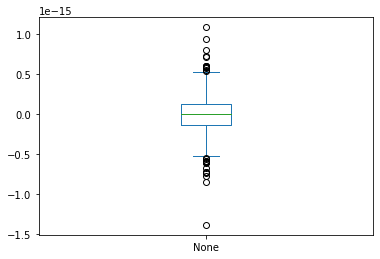

In [12]:
# check: 平減後資料的各公司平均數非常接近0 

X_deflate.mean(axis = 1).plot.box()

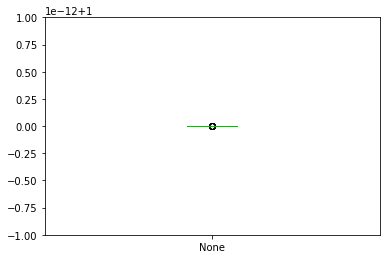

In [13]:
# check: 平減後資料的各公司t-48 ~ t-1期標準差非常接近1

X_deflate.std(axis = 1).plot.box()

# 四、random forest
[模型介紹網站](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)<br>
使用模型時應注意，模型輸入的變數名稱只能是字串，因此dtypes: ['Period']是不能直接輸入的。<br>

## 4.1 資料準備: 以預測2016/1的signal為例
我們需要把X的欄位改寫成t-48 ~ t-1的字串，因為欄位名稱會自動變成模型的變數名稱，我們修改變數名稱會方便後續的資料測試！

In [14]:
# X 原始資料

X = explanable_mon(remain,2016,1,48)
X.columns = ["t-"+str(t) for t in range(48,0,-1) ]

# X 平減後資料

X_deflate = X.apply(lambda x:(x-x.mean())/x.std(),axis = 1)

In [15]:
# y
y = signal_f(remain,2016,1)

## 4.2 訓練模型

### 4.2.1 原始資料

In [16]:
# 呼叫random forest分類器，命名為rf1
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(random_state = 0) 

In [17]:
# 訓練模型
rf1.fit(X,y)

RandomForestClassifier(random_state=0)

In [18]:
# 模型的score: 指定X與y，計算訓練完畢的模型對該組資料的預測準確率
rf1.score(X,y) # 此處放入訓練資料，表示欲求訓練集的準確率

1.0

### 4.2.2 平減後資料

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(random_state = 0) 
rf2.fit(X_deflate,y)
rf2.score(X_deflate,y)

1.0

## 4.2 測試模型
我們會希望有測試資料集可以檢視該訓練完畢的模型預測能力，假設我們往後推移一個月，嘗試預測2016/2的signal

In [20]:
# 資料準備: 原始資料

X_test = explanable_mon(remain,2016,2,48)
X_test.columns = ["t-"+str(t) for t in range(48,0,-1) ] # 照樣記得改變變數名稱，才能放入對應的位置
y_test = signal_f(remain,2016,2)

# 資料準備: 平減後資料

X_deflate_test = X_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)

In [19]:
# 模型測試準確率結果： （原始資料）

rf1.score(X_test,y_test)

0.5359477124183006

In [20]:
# 模型測試準確率結果：比原始資料訓練的模型更高一些，因此可推得知標準化是有效的。

rf2.score(X_deflate_test,y_test)

0.6094771241830066

# 五、XGBoost
[資料來源](https://xgboost.readthedocs.io/en/stable/parameter.html)

## 5.1 套件下載
在本機跑此模型時，可能會因為版本問題導致無法成功執行，建議安裝0.90版本，成功率較高。

In [26]:
# 安裝

! pip3 install xgboost==0.90

In [21]:
# 嘗試執行套件，並且確認版本

import xgboost
print(xgboost.__version__)

0.90


## 5.2 模型訓練: 以預測2016/1的signal為例

In [22]:
# 原始資料

from xgboost import XGBClassifier
xgb1 = XGBClassifier()
xgb1.fit(X, y)

# 平減後資料

xgb2 = XGBClassifier()
xgb2.fit(X_deflate, y)

XGBClassifier()

## 5.3 測試模型與結果

In [23]:
print(f"原始資料訓練的模型，平移一個月的測試準確率為{xgb1.score(X_test,y_test)}")
print(f"平減後資料訓練的模型，平移一個月的測試準確率為{xgb2.score(X_deflate_test,y_test)}")

原始資料訓練的模型，平移一個月的測試準確率為0.5972222222222222
平減後資料訓練的模型，平移一個月的測試準確率為0.6429738562091504


# 六、整體平移一個月當作測試資料
接著我們嘗試大範圍的計算。剛剛上述都是以2012/1 ~ 2015/12為X訓練集、2016/1的signal為y訓練集，且以平移一個月的資料為測試集，接下來我們嘗試從訓練2012/1 ~ 2015/12的資料，一路平移一個月，查看往後每個區間預測下個月的測試準確率為多少，一直到2019/1為最後的y訓練集。<br>
<br>
也就是說，接下來搜集的36筆測試準確率當中，<br>
第一筆會是「以2012/1 ~ 2015/12為X訓練集、2016/1的signal為y訓練集；以2012/2 ~ 2016/1為X測試集、2016/2的signal為y測試集」所得之測試準確率，<br>
第二筆會是「以2012/2 ~ 2016/1為X訓練集、2016/2的signal為y訓練集；以2012/3 ~ 2016/2為X測試集、2016/3的signal為y測試集」所得之測試準確率，<br>
以此類推，<br>
最後一筆會是「以2014/12 ~ 2018/11為X訓練集、2018/12的signal為y訓練集；以2015/1 ~ 2018/12為X測試集、2019/1的signal為y測試集」所得之測試準確率。

## 6.1 如何往後推算月份
與同2.1部分的往前推算雷同。

In [23]:
def forward_time(yr,mon,b):
    '''輸入的變數定義： yr = 第t期的年; mon = 第t期的月; b = 往前推算幾個月'''
    if mon+b<=12:                       # 若當下月份(mon)加上往後期數(b)小於12，即還在同一年內
        return str(yr)+"-"+str(mon+b)       # 直接返回當下年份(yr)，以及當下月份(mon)減除往前期數(b)，所組成的字串
    else:                               # 若當下月份(mon)減除往前期數(b)超出12，即不屬於同一年了
        return forward_time(yr+1,mon,b-12)     # 就再跑一次forward_time，不過此次直接手動調增一年、將往後期數(b)同時減少12個月

In [24]:
# 測試

forward_time(2015,11,3)

'2016-2'

## 6.2 平移一個月

In [25]:
import time
start = time.time()

# 搜集我要訓練的每個年月，根據上述是從2016/1至2018/12，即從2016/1往後0至35個月：
months = [forward_time(2016,1,b) for b in range(3*12)]

test_y_m = []       # 紀錄測試的年月
rf_org = []    # 紀錄random forest原始資料的測試準確率
rf_def = []    # 紀錄random forest平減資料的測試準確率
xgb_org = []    # 紀錄xgboost原始資料的測試準確率
xgb_def = []    # 紀錄xgboost平減資料的測試準確率
gbm_org = []
gbm_def = []

for i in months: # 針對每個我欲訓練的年月
    year = int(i.split("-")[0])                         # 訓練的年
    month = int(i.split("-")[1])                        # 訓練的月
    
    # 此時y測試集年月應為forward_time(year,month,1)
    test = forward_time(year,month,1)
    year_test = int(test.split("-")[0])                 # 測試的年
    mon_test = int(test.split("-")[1])                  # 測試的月
    test_y_m.append(test)                               # 搜集測試的年月，作為紀錄
    
    #-----------------------開始資料準備-----------------------
    # X,y 原始資料訓練集
    X = explanable_mon(remain,year,month,48)
    X.columns = ["t-"+str(t) for t in range(48,0,-1) ]
    y = signal_f(remain,year,month)

    # X 平減後資料訓練集
    X_deflate = X.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
    
    # X,y 原始資料測試集
    X_test = explanable_mon(remain,year_test,mon_test,48)
    X_test.columns = ["t-"+str(t) for t in range(48,0,-1) ] # 照樣記得改變變數名稱，才能放入對應的位置
    y_test = signal_f(remain,year_test,mon_test)

    # X 平減後資料測試集
    X_deflate_test = X_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
    
    #-----------------------開始模型訓練-----------------------
    # random forest:
    rf1 = RandomForestClassifier(random_state = 0) 
    rf1.fit(X,y) 
    rf2 = RandomForestClassifier(random_state = 0) 
    rf2.fit(X_deflate,y)
    
    # xgboost:
    xgb1 = XGBClassifier()
    xgb1.fit(X, y)
    xgb2 = XGBClassifier()
    xgb2.fit(X_deflate, y)

    # lightGBM:
    gbm_1 = ltb.LGBMClassifier()
    gbm_2 = ltb.LGBMClassifier()
    gbm_1.fit(X,y)
    gbm_2.fit(X_deflate, y)

    #-----------------------開始儲存測試結果-----------------------
    rf_org.append(rf1.score(X_test,y_test))
    rf_def.append(rf2.score(X_deflate_test,y_test))
    xgb_org.append(xgb1.score(X_test,y_test))
    xgb_def.append(xgb2.score(X_deflate_test,y_test))
    gbm_org.append(gbm_1.score(X_test,y_test))
    gbm_def.append(gbm_2.score(X_deflate_test,y_test))
    
print("Using time:","%.3f"%(time.time()-start)," secs.")

KeyboardInterrupt: ignored

## 6.3 畫圖呈現整體結果

### 6.3.1 折線圖：全部畫在一起

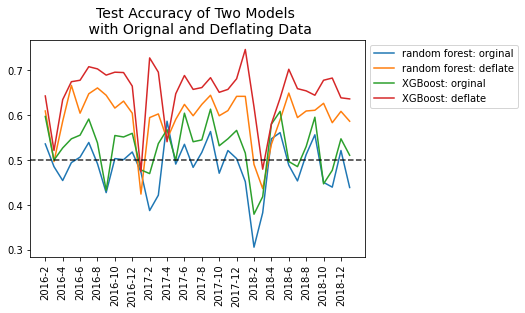

In [34]:
plt.title("Test Accuracy of Two Models \n with Orignal and Deflating Data",size = 14)
plt.plot(test_y_m,rf_org,label = "random forest: orginal")
plt.plot(test_y_m,rf_def,label = "random forest: deflate")
plt.plot(test_y_m,xgb_org,label = "XGBoost: orginal")
plt.plot(test_y_m,xgb_def,label = "XGBoost: deflate")
plt.xticks(range(0,len(test_y_m),2),test_y_m[::2],rotation=90)
plt.axhline(0.5, color = 'black',ls = '--',alpha = 0.8) # 添加水平線於y = 0.5的地方
plt.legend(bbox_to_anchor = (1,1),loc = 'upper left')
plt.show()

### 6.3.2 折線圖：分模型畫圖

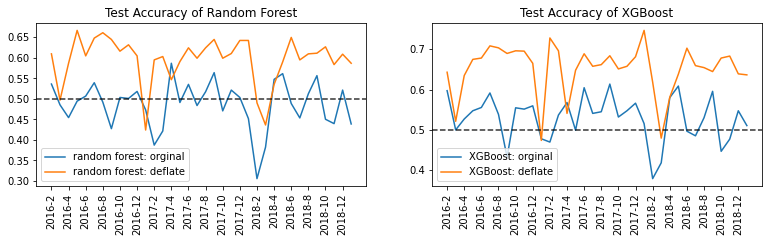

In [35]:
plt.figure(figsize = (13,3))

plt.subplot(1,2,1)
plt.title("Test Accuracy of Random Forest")
plt.plot(test_y_m,rf_org,label = "random forest: orginal")
plt.plot(test_y_m,rf_def,label = "random forest: deflate")
plt.xticks(range(0,len(test_y_m),2),test_y_m[::2],rotation=90)
plt.axhline(0.5, color = 'black',ls = '--',alpha = 0.8) # 添加水平線於y = 0.5的地方
plt.legend()

plt.subplot(1,2,2)
plt.title("Test Accuracy of XGBoost")
plt.plot(test_y_m,xgb_org,label = "XGBoost: orginal")
plt.plot(test_y_m,xgb_def,label = "XGBoost: deflate")
plt.xticks(range(0,len(test_y_m),2),test_y_m[::2],rotation=90)
plt.axhline(0.5, color = 'black',ls = '--',alpha = 0.8) # 添加水平線於y = 0.5的地方
plt.legend();

# plt.subplots_adjust(wspace=0.55)

### 6.3.3 盒鬚圖

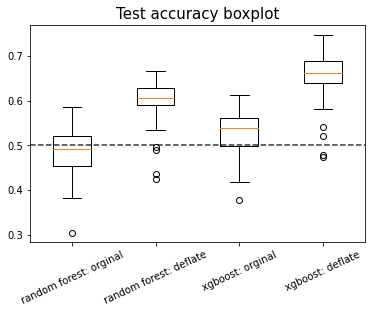

In [36]:
plt.title("Test accuracy boxplot",size = 15)
plt.boxplot([rf_org,rf_def, xgb_org, xgb_def])
plt.axhline(0.5, color = 'black',ls = '--',alpha = 0.8) # 添加水平線於y = 0.5的地方
plt.xticks([1, 2, 3, 4], ['random forest: orginal', 'random forest: deflate', 'xgboost: orginal','xgboost: deflate'],
          rotation = 25)
plt.show()

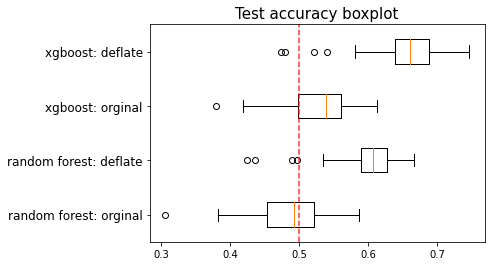

In [37]:
plt.title("Test accuracy boxplot",size = 15)
plt.boxplot([rf_org,rf_def, xgb_org, xgb_def],vert = False)
plt.axvline(0.5, color = 'red',ls = '--',alpha = 0.8) # 添加垂直線於x = 0.5的地方
plt.yticks([1, 2, 3, 4], ['random forest: orginal', 'random forest: deflate', 'xgboost: orginal','xgboost: deflate'],size = 12)
plt.show()

## 6.4 討論最好與最差的模型
以上兩種模型與兩種資料所得到的四種結果，每一種都是一路從預測2016/2的signal至2019/1的signal共36個模型的測試結果，現在我們希望討論其中表現最好以及最差的一個模型結果，討論其分類結果以及變數重要性。首先，需要找出最佳與最差的模型。

### 6.4.1 找出最好與最差模型
從6.3.1的折線圖或6.3.3的盒鬚圖可以觀察出，最低test accuracy與最高test accuracy的模型結果，分別發生在以原始資料訓練的random forest、以平減後資料訓練的xgboost兩條結果當中，至於實際發生於預測和月份，雖可以目測，也可以簡單用程式找出。

In [38]:
print(f"The lowest test accuracy is {min(rf_org)} when predicting {test_y_m[rf_org.index(min(rf_org))]}.")

The lowest test accuracy is 0.3055555555555556 when predicting 2018-2.


In [39]:
print(f"The highest test accuracy is {max(xgb_def)} when predicting {test_y_m[xgb_def.index(max(xgb_def))]}.")

The highest test accuracy is 0.7467320261437909 when predicting 2018-1.


接著再做一次兩模型，因為我們希望討論的分類結果與變數重要性是在個別模型裡發生的，6.2步驟中僅存取每個模型的預測結果，沒有儲存個別模型的分類結果與變數重要性。

In [40]:
#############
# 最差模型：  #
#############

# X,y 訓練集
X_worst = explanable_mon(remain,2018,1,48) # 注意：預測2018-2 signal時結果差，表示其y訓練集為往前一個月份的2018-1的signal
X_worst.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_worst = signal_f(remain,2018,1)

# X,y 測試集
X_worst_test = explanable_mon(remain,2018,2,48) 
X_worst_test.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_worst_test = signal_f(remain,2018,2)

# 模型訓練
rf_worst = RandomForestClassifier(random_state = 0) 
rf_worst.fit(X_worst,y_worst) 

#############
# 最佳模型：  #
#############

# X,y 訓練集
X_best = explanable_mon(remain,2017,12,48) # 注意：預測2018-1 signal時結果佳，表示其y訓練集為往前一個月份的2017-12的signal
X_best = X_best.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
X_best.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_best = signal_f(remain,2017,12)

# X,y 測試集
X_best_test = explanable_mon(remain,2018,1,48) 
X_best_test = X_best_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
X_best_test.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_best_test = signal_f(remain,2018,1)

# 模型訓練
xgb_best = XGBClassifier()
xgb_best.fit(X_best, y_best)

XGBClassifier()

### 6.4.2 Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns           
import matplotlib.pyplot as plt

#### 6.4.2.1 最差模型
得知模型預測結果當中，有高達811筆，即有$811\div1224\approx 66\%$的比例是誤將實為不如預期的月營收，高估為達到預期的月營收，而低估的比率相對較低，因此應注意此模型相對容易過於樂觀，缺乏挖掘較差月營收資訊的能力。

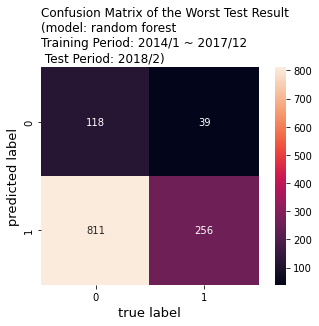

In [42]:
# 首先得到模型預測值
worst_pred = rf_worst.predict(X_worst_test)

# 準備confusion matrix: 先填入真實值，再填入預測值
mat = confusion_matrix(y_worst_test, worst_pred) 

# 繪製heatmap
# (注意矩陣要轉置，因為混淆矩陣的 y label應為predicted label，但sklearn.metrics.confusion_matrix的y軸是true label)
plt.title("Confusion Matrix of the Worst Test Result \n(model: random forest\nTraining Period: 2014/1 ~ 2017/12  \n Test Period: 2018/2)",loc = "left")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label',size = 13)
plt.ylabel('predicted label',size = 13);

#### 6.4.2.2 最佳模型
模型誤判的結果中，高估與低估的比數差異不大，可知模型較不會偏頗判斷，而從兩個類別分開觀察準確率，真實為達預期月營收的資料準確率為$705\div(184+705)\approx 79\%$，真實為未達預期月營收的資料準確率為$209\div(209+126)\approx 62\%$，得知個別來看，模型學習「達預期月營收資料」的特稱還是較多。

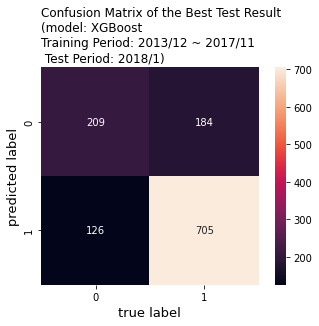

In [43]:
best_pred = xgb_best.predict(X_best_test)
mat2 = confusion_matrix(y_best_test, best_pred) 
plt.title("Confusion Matrix of the Best Test Result \n(model: XGBoost\nTraining Period: 2013/12 ~ 2017/11  \n Test Period: 2018/1)",loc = "left")
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label',size = 13)
plt.ylabel('predicted label',size = 13);

### 6.4.3 feature importance
由以下結果可觀察得，兩模型重要變數的排序明顯不同。

#### 6.4.3.1 最差模型

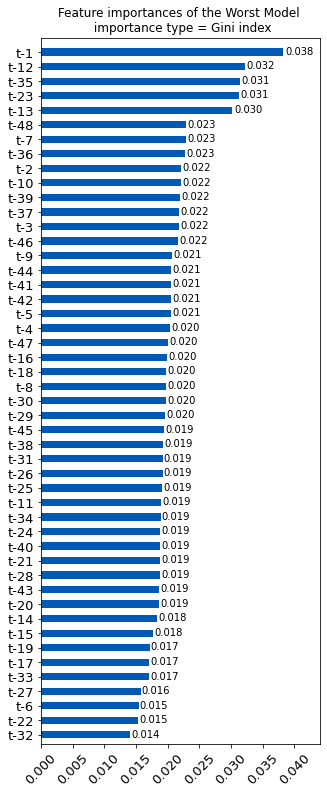

In [44]:
ft_name = rf_worst.feature_names_in_
typ = "Gini index"

imp = pd.Series(rf_worst.feature_importances_,index = ft_name).sort_values()
imp = imp[imp>0] # 刪去重要性為0的變數，不用畫在圖上

# Plot 
imp.plot.barh(figsize = (5,13),
              title = f"Feature importances of the Worst Model \n importance type = {typ}",
              color = "#005AB5",fontsize=13)

# 增添標籤，在每個bar前方增加該變數的重要性
for a,b in zip(range(imp.shape[0]),imp.values):
    plt.text(b*1.01,a-0.15, '%.3f' % b,fontsize=10)

plt.xlim([0,max(imp)*1.15])
plt.ylim([-0.65,imp.shape[0]])
plt.xticks(rotation = 45)
plt.show()

#### 6.4.3.2 最佳模型

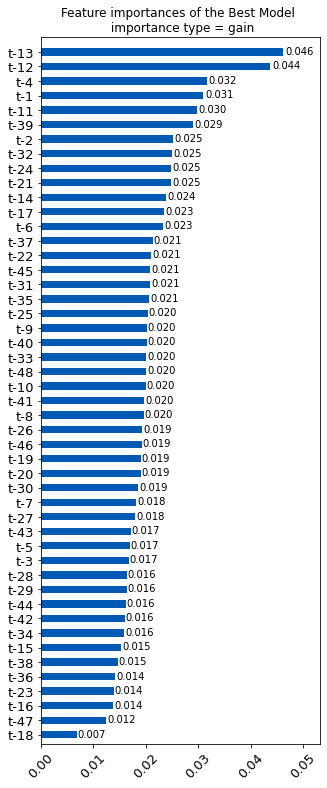

In [46]:
ft_name = xgb_best.get_booster().feature_names
typ = xgb_best.importance_type

imp = pd.Series(xgb_best.feature_importances_,index = ft_name).sort_values()
imp = imp[imp>0] # 刪去重要性為0的變數，不用畫在圖上
imp.plot.barh(figsize = (5,13),
              title = f"Feature importances of the Best Model \n importance type = {typ}",
              color = "#005AB5",fontsize=13)
for a,b in zip(range(imp.shape[0]),imp.values):
    plt.text(b*1.01,a-0.15, '%.3f' % b,fontsize=10)

plt.xlim([0,max(imp)*1.15])
plt.ylim([-0.65,imp.shape[0]])
plt.xticks(rotation = 45)
plt.show()

# 七、動手做時間！

## 另有一份pdf檔的詳細說明，請助教參閱評分。

['作業說明']<https://reurl.cc/1Z2oe8>

## 第一部分：使用lightGBM
嘗試再多用一個模型：lightGBM。分析一樣的時間範圍，並且討論lightGBM最佳的模型，是否變數重要性、分類結果有異於其他模型。
> 注意：在本機直接想下載lightGBM會有些困難重重，建議大家用google colab，進行`!pip3 install lightgbm`然後`import lightgbm`就可以輕鬆成功！
## 第二部分：鎖定產業進行分析
自行挑選一個產業類型，討論其月營收signal的預測成果。產業範圍可以自行界定，如電子業、半導體業等皆可，各公司所屬TEJ產業可參考附件「TEJ產業.xlsx」；所使用的模型則由Random Forest、XGBoost、lightGBM中選擇一個，訓練後報導其成效即可；討論之時間範圍如同上述示範期間。
> 注意：決定資料是否進行平減、如何進行平減，也是你實驗設計中的一環！

In [24]:
import time
start = time.time()

# 搜集我要訓練的每個年月，根據上述是從2016/1至2018/12，即從2016/1往後0至35個月：
months = [forward_time(2016,1,b) for b in range(3*12)]

test_y_m = []       # 紀錄測試的年月
gbm_org = []
gbm_def = []

for i in months: # 針對每個我欲訓練的年月
    year = int(i.split("-")[0])                         # 訓練的年
    month = int(i.split("-")[1])                        # 訓練的月
    
    # 此時y測試集年月應為forward_time(year,month,1)
    test = forward_time(year,month,1)
    year_test = int(test.split("-")[0])                 # 測試的年
    mon_test = int(test.split("-")[1])                  # 測試的月
    test_y_m.append(test)                               # 搜集測試的年月，作為紀錄
    
    #-----------------------開始資料準備-----------------------
    # X,y 原始資料訓練集
    X = explanable_mon(remain,year,month,48)
    X.columns = ["t-"+str(t) for t in range(48,0,-1) ]
    y = signal_f(remain,year,month)

    # X 平減後資料訓練集
    X_deflate = X.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
    
    # X,y 原始資料測試集
    X_test = explanable_mon(remain,year_test,mon_test,48)
    X_test.columns = ["t-"+str(t) for t in range(48,0,-1) ] # 照樣記得改變變數名稱，才能放入對應的位置
    y_test = signal_f(remain,year_test,mon_test)

    # X 平減後資料測試集
    X_deflate_test = X_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
    
    #-----------------------開始模型訓練-----------------------
    # lightGBM:
    gbm_1 = ltb.LGBMClassifier()
    gbm_2 = ltb.LGBMClassifier()
    gbm_1.fit(X,y)
    gbm_2.fit(X_deflate, y)

    #-----------------------開始儲存測試結果-----------------------
    gbm_org.append(gbm_1.score(X_test,y_test))
    gbm_def.append(gbm_2.score(X_deflate_test,y_test))
    
print("Using time:","%.3f"%(time.time()-start)," secs.")

Using time: 96.782  secs.


In [39]:
print(f"The lowest test accuracy is {min(gbm_org)} when predicting {test_y_m[gbm_org.index(min(gbm_org))]}.")
print(f"The lowest test accuracy is {min(gbm_def)} when predicting {test_y_m[gbm_def.index(min(gbm_def))]}.")
print(f"The highest test accuracy is {max(gbm_org)} when predicting {test_y_m[gbm_org.index(max(gbm_org))]}.")
print(f"The highest test accuracy is {max(gbm_def)} when predicting {test_y_m[gbm_def.index(max(gbm_def))]}.")

The lowest test accuracy is 0.4599673202614379 when predicting 2018-3.
The lowest test accuracy is 0.4722222222222222 when predicting 2017-1.
The highest test accuracy is 0.6184640522875817 when predicting 2017-9.
The highest test accuracy is 0.7410130718954249 when predicting 2017-2.


In [43]:
#############
# 最差模型：  #
#############

# X,y 訓練集
X_worst = explanable_mon(remain,2018,2,48) # 注意：預測2018-2 signal時結果差，表示其y訓練集為往前一個月份的2018-1的signal
X_worst.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_worst = signal_f(remain,2018,2)

# X,y 測試集
X_worst_test = explanable_mon(remain,2018,3,48) 
X_worst_test.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_worst_test = signal_f(remain,2018,3)

# 模型訓練
gbm_worst = ltb.LGBMClassifier()
gbm_worst.fit(X_worst,y_worst) 

#############
# 最佳模型：  #
#############

# X,y 訓練集
X_best = explanable_mon(remain,2017,1,48) # 注意：預測2018-1 signal時結果佳，表示其y訓練集為往前一個月份的2017-12的signal
X_best = X_best.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
X_best.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_best = signal_f(remain,2017,1)

# X,y 測試集
X_best_test = explanable_mon(remain,2017,2,48) 
X_best_test = X_best_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
X_best_test.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_best_test = signal_f(remain,2017,2)

# 模型訓練
gbm_best = ltb.LGBMClassifier()
gbm_best.fit(X_best, y_best)

LGBMClassifier()

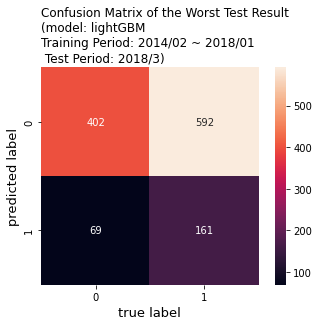

In [28]:
# 首先得到模型預測值
worst_pred = gbm_worst.predict(X_worst_test)

# 準備confusion matrix: 先填入真實值，再填入預測值
mat = confusion_matrix(y_worst_test, worst_pred) 

# 繪製heatmap
# (注意矩陣要轉置，因為混淆矩陣的 y label應為predicted label，但sklearn.metrics.confusion_matrix的y軸是true label)
plt.title("Confusion Matrix of the Worst Test Result \n(model: lightGBM\nTraining Period: 2014/02 ~ 2018/01  \n Test Period: 2018/3)",loc = "left")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label',size = 13)
plt.ylabel('predicted label',size = 13);

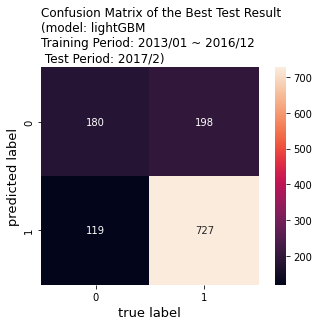

In [29]:
best_pred = gbm_best.predict(X_best_test)
mat2 = confusion_matrix(y_best_test, best_pred) 
plt.title("Confusion Matrix of the Best Test Result \n(model: lightGBM\nTraining Period: 2013/01 ~ 2016/12  \n Test Period: 2017/2)",loc = "left")
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label',size = 13)
plt.ylabel('predicted label',size = 13);

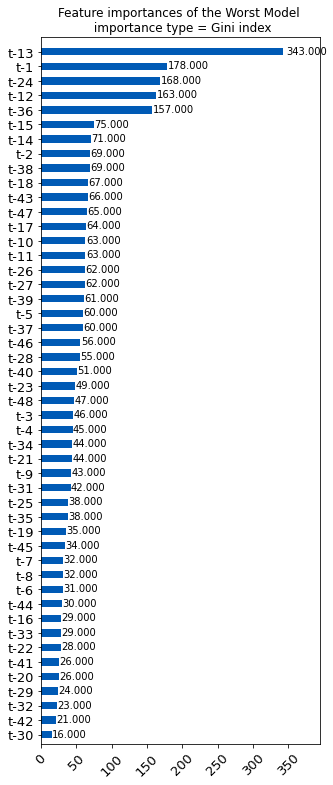

In [30]:
ft_name = gbm_worst.booster_.feature_name()
typ = "Gini index"

imp = pd.Series(gbm_worst.feature_importances_,index = ft_name).sort_values()
imp = imp[imp>0] # 刪去重要性為0的變數，不用畫在圖上

# Plot 
imp.plot.barh(figsize = (5,13),
              title = f"Feature importances of the Worst Model \n importance type = {typ}",
              color = "#005AB5",fontsize=13)

# 增添標籤，在每個bar前方增加該變數的重要性
for a,b in zip(range(imp.shape[0]),imp.values):
    plt.text(b*1.01,a-0.15, '%.3f' % b,fontsize=10)

plt.xlim([0,max(imp)*1.15])
plt.ylim([-0.65,imp.shape[0]])
plt.xticks(rotation = 45)
plt.show()

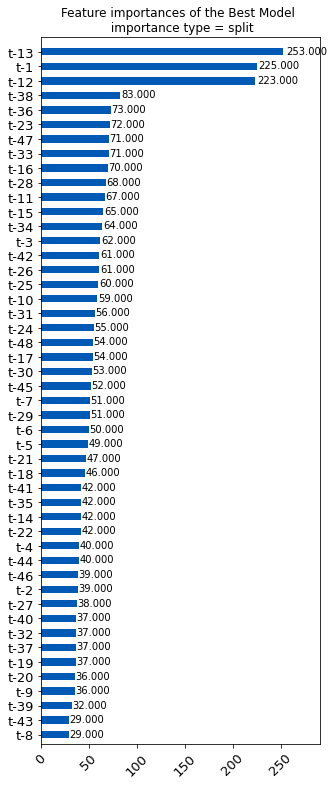

In [44]:
ft_name = gbm_best.booster_.feature_name()
typ = gbm_best.importance_type

imp = pd.Series(gbm_best.feature_importances_,index = ft_name).sort_values()
imp = imp[imp>0] # 刪去重要性為0的變數，不用畫在圖上
imp.plot.barh(figsize = (5,13),
              title = f"Feature importances of the Best Model \n importance type = {typ}",
              color = "#005AB5",fontsize=13)
for a,b in zip(range(imp.shape[0]),imp.values):
    plt.text(b*1.01,a-0.15, '%.3f' % b,fontsize=10)

plt.xlim([0,max(imp)*1.15])
plt.ylim([-0.65,imp.shape[0]])
plt.xticks(rotation = 45)
plt.show()

In [45]:
industry = pd.read_excel("./TEJ產業.xlsx") #,index_col="公司"
elec = []
for i in industry['公司']:
  if "24" == i[0:2]:
    elec.append(i)
new_remain = remain[remain.index.isin(elec)]

In [46]:
import time
start = time.time()

# 搜集我要訓練的每個年月，根據上述是從2016/1至2018/12，即從2016/1往後0至35個月：
months = [forward_time(2016,1,b) for b in range(3*12)]

test_y_m = []       # 紀錄測試的年月
gbm_def = []

for i in months: # 針對每個我欲訓練的年月
    year = int(i.split("-")[0])                         # 訓練的年
    month = int(i.split("-")[1])                        # 訓練的月
    
    # 此時y測試集年月應為forward_time(year,month,1)
    test = forward_time(year,month,1)
    year_test = int(test.split("-")[0])                 # 測試的年
    mon_test = int(test.split("-")[1])                  # 測試的月
    test_y_m.append(test)                               # 搜集測試的年月，作為紀錄
    
    #-----------------------開始資料準備-----------------------
    # X,y 原始資料訓練集
    X = explanable_mon(new_remain,year,month,48)
    X.columns = ["t-"+str(t) for t in range(48,0,-1) ]
    y = signal_f(new_remain,year,month)

    # X 平減後資料訓練集
    X_deflate = X.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
    
    # X,y 原始資料測試集
    X_test = explanable_mon(new_remain,year_test,mon_test,48)
    X_test.columns = ["t-"+str(t) for t in range(48,0,-1) ] # 照樣記得改變變數名稱，才能放入對應的位置
    y_test = signal_f(new_remain,year_test,mon_test)

    # X 平減後資料測試集
    X_deflate_test = X_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
    
    #-----------------------開始模型訓練-----------------------
    # lightGBM:
    gbm = ltb.LGBMClassifier()
    gbm.fit(X_deflate, y)

    #-----------------------開始儲存測試結果-----------------------
    gbm_def.append(gbm.score(X_deflate_test,y_test))
    
print("Using time:","%.3f"%(time.time()-start)," secs.")

Using time: 2.999  secs.


In [62]:
print(f"The highest test accuracy is {max(gbm_def)} when predicting {test_y_m[gbm_def.index(max(gbm_def))]}.")

The highest test accuracy is 0.6712328767123288 when predicting 2018-4.


In [47]:
#############
# 最佳模型：  #
#############

# X,y 訓練集
X_best = explanable_mon(new_remain,2018,3,48) # 注意：預測2018-1 signal時結果佳，表示其y訓練集為往前一個月份的2017-12的signal
X_best = X_best.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
X_best.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_best = signal_f(new_remain,2018,3)

# X,y 測試集
X_best_test = explanable_mon(new_remain,2018,4,48) 
X_best_test = X_best_test.apply(lambda x:(x-x.mean())/x.std(),axis = 1)
X_best_test.columns = ["t-"+str(t) for t in range(48,0,-1) ]
y_best_test = signal_f(new_remain,2018,4)

# 模型訓練
gbm_best = ltb.LGBMClassifier()
gbm_best.fit(X_best, y_best)

LGBMClassifier()

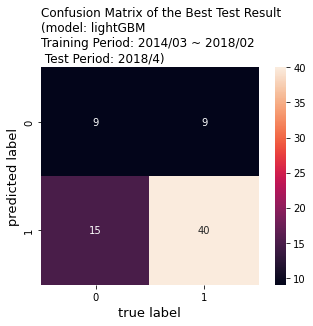

In [40]:
best_pred = gbm_best.predict(X_best_test)
mat2 = confusion_matrix(y_best_test, best_pred) 
plt.title("Confusion Matrix of the Best Test Result \n(model: lightGBM\nTraining Period: 2014/03 ~ 2018/02  \n Test Period: 2018/4)",loc = "left")
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label',size = 13)
plt.ylabel('predicted label',size = 13);

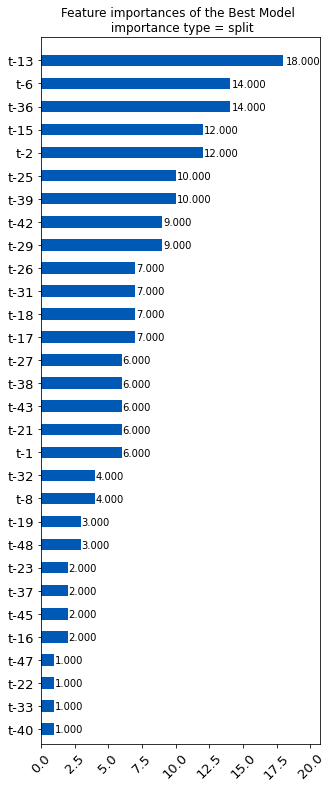

In [48]:
ft_name = gbm_best.booster_.feature_name()
typ = gbm_best.importance_type

imp = pd.Series(gbm_best.feature_importances_,index = ft_name).sort_values()
imp = imp[imp>0] # 刪去重要性為0的變數，不用畫在圖上
imp.plot.barh(figsize = (5,13),
              title = f"Feature importances of the Best Model \n importance type = {typ}",
              color = "#005AB5",fontsize=13)
for a,b in zip(range(imp.shape[0]),imp.values):
    plt.text(b*1.01,a-0.15, '%.3f' % b,fontsize=10)

plt.xlim([0,max(imp)*1.15])
plt.ylim([-0.65,imp.shape[0]])
plt.xticks(rotation = 45)
plt.show()